# This is a conversation analysis. The texts are from my own Whatsapp group chat

Note: Some codes are reused from other sources.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import collections
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Import and process the chat

In [2]:
#extract the date time
def startsWithDateTime(s):
    pattern = '^(([0-9])|((1)[0-2]))(\/)((([0-2][0-9]|(3)[0-1]))|([0-9]|(3)[0-1]))(\/)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [3]:
#extract the name
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{2} \d{3} \d{2} \d{2}):',   # Mobile Number (VN)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [4]:
#extract the message
def getDataPoint(line):
    # line = 18/06/17, 22:47 - Loki: Why do you have 2 numbers, Banner?
    
    splitLine = line.split(' - ') # splitLine = ['18/06/17, 22:47', 'Loki: Why do you have 2 numbers, Banner?']
    
    dateTime = splitLine[0] # dateTime = '18/06/17, 22:47'
    
    date, time = dateTime.split(', ') # date = '18/06/17'; time = '22:47'
    
    message = ' '.join(splitLine[1:]) # message = 'Loki: Why do you have 2 numbers, Banner?'
    
    if startsWithAuthor(message): # True
        splitMessage = message.split(': ') # splitMessage = ['Loki', 'Why do you have 2 numbers, Banner?']
        author = splitMessage[0] # author = 'Loki'
        message = ' '.join(splitMessage[1:]) # message = 'Why do you have 2 numbers, Banner?'
    else:
        author = None
    return date, time, author, message

In [5]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = 'C:\\Users\\Chau Chu\\Documents\\Study\\Kaggle\\WS project\\WS chat.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)
        
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None # Intermediate variables to keep track of the current message being processed
    
    while True:
        line = fp.readline() 
        if not line: # Stop reading further if end of file has been reached
            break
        line = line.strip() # Guarding against erroneous leading and trailing whitespaces
        if startsWithDateTime(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() # Clear the message buffer so that it can be used for the next message
            date, time, author, message = getDataPoint(line) # Identify and extract tokens from the line
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer


In [6]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])

In [7]:
#check the author name
df['Author'].unique()

array(['Chau Chu', 'Tu Nguyen Anh', 'Bui Bach', 'Minh A3', 'Nam Kaze',
       'Huy Kò', 'Tuấn A2', 'Chân Đi Không', 'Việt R10', None, 'Việt Bí'],
      dtype=object)

In [8]:
#change authors' names to shorter names
df['Author']=df['Author'].replace({'Minh A3':'MC', 'Huy Kò':'HK', 'Chân Đi Không':'CP',
       'Tuấn A2':'TA', 'Nam Kaze':'NB', 'Chau Chu':'CC',
       'Tu Nguyen Anh':'TU', 'Việt R10':'R10', 'Bui Bach':'BB',
       'Việt Bí':'TV', 'Bui Bach':'BB'})
#change null value to System
df['Author'].fillna('System',inplace=True)

In [9]:
#turn date into date format and remove the default time 00.00.00
df['timestamp'] = df['Date']+  " " + df['Time']
df['Date'] = pd.to_datetime(df['Date'])

#select the messages in July 2020
thang7 = df[(df['Date']>='2020-07-01') & (df['Date']<='2020-07-31')]
thang7['Date'] = thang7['Date'].dt.date

In [10]:
#count letters and words use in message
thang7['Letter_Count'] = thang7['Message'].apply(lambda s : len(s))
thang7['Word_Count'] = thang7['Message'].apply(lambda s : len(s.split(' ')))

In [11]:
#drop message that has more than 100 words
index =thang7[thang7['Word_Count']>100].index
thang7.drop(index,inplace=True)

In [12]:
#add the weekday information
from datetime import date

thang7['Weekday']=thang7['Date'].apply(lambda x:x.weekday())
thang7['Weekday']=thang7['Weekday'].replace({0:'Mon',1:'Tue',2:'Wed',
                                    3:'Thu',4:'Fri',5:'Sat',6:'Sun'})

In [13]:
thang7.head()

,Date,Time,Author,Message,timestamp,Letter_Count,Word_Count,Weekday
22424,2020-07-01,06:02,NB,Ủa sang làm DN thì k làm chung lotte nữa ah,7/1/20 06:02,43,11,Wed
22425,2020-07-01,06:03,NB,Đi ctay nghe mùi mẫn vl :)),7/1/20 06:03,27,7,Wed
22426,2020-07-01,06:18,HK,Chúc tuấn thành công ở vị trí mới,7/1/20 06:18,33,8,Wed
22427,2020-07-01,06:18,HK,Đập tan thách thức khai lối dẫn đầu,7/1/20 06:18,35,8,Wed
22428,2020-07-01,06:21,MC,Tuấn làm quả mail chia tay đồng đội cũ như sếp...,7/1/20 06:21,94,21,Wed


In [14]:
thang7['timestamp'] = pd.to_datetime(df.timestamp)

In [15]:
# find time difference between current and previous message
thang7['reply_time'] = (thang7.timestamp.shift(-1) - thang7.timestamp).apply(lambda x: x.total_seconds()/60).fillna(np.inf)
#if reply time is more than 20 mins add 1 to counter
thang7['conversation'] = (thang7.reply_time > 30).cumsum().shift(1).fillna(0).astype(int) + 1

df3 = thang7.groupby('conversation').agg({'timestamp': ['min', 'max', 'count'], 
                                      'Author': ['first', 'unique', 'nunique']})

df3['duration'] = (df3['timestamp']['max'] - df3['timestamp']['min']).apply(lambda x: x.total_seconds()/60)

In [16]:
df3

timestamp                           Author  \
                             min                 max count  first   
conversation                                                        
1            2020-07-01 06:02:00 2020-07-01 06:49:00    94     NB   
2            2020-07-01 07:25:00 2020-07-01 08:19:00    45     BB   
3            2020-07-01 12:13:00 2020-07-01 16:05:00   615     MC   
4            2020-07-01 16:42:00 2020-07-01 16:44:00    18     HK   
5            2020-07-01 17:16:00 2020-07-01 17:45:00    22     HK   
...                          ...                 ...   ...    ...   
211          2020-07-31 08:37:00 2020-07-31 08:44:00     4     MC   
212          2020-07-31 09:37:00 2020-07-31 10:22:00    15     HK   
213          2020-07-31 11:29:00 2020-07-31 12:31:00    95    R10   
214          2020-07-31 13:44:00 2020-07-31 13:49:00     6     HK   
215          2020-07-31 20:21:00 2020-07-31 20:21:00     3     TA   

                                                                duration  
                                                 unique nunique           
conversation                                                              
1                             [NB, HK, MC, R10, TA, TU]       6     47.0  
2                                 [BB, R10, HK, CC, MC]       5     54.0  
3             [MC, HK, TA, R10, CC, BB, TU, NB, System]       9    232.0  
4                                      [HK, TA, NB, MC]       4      2.0  
5                                          [HK, MC, CC]       3     29.0  
...                                                 ...     ...      ...  
211                                            [MC, CC]       2      7.0  
212                           [HK, TA, R10, NB, MC, CC]       6     45.0  
213                           [R10, HK, MC, TU, NB, CC]       6     62.0  
214                                            [HK, TU]       2      5.0  
215                                                [TA]       1      0.0  

[215 rows x 7 columns]

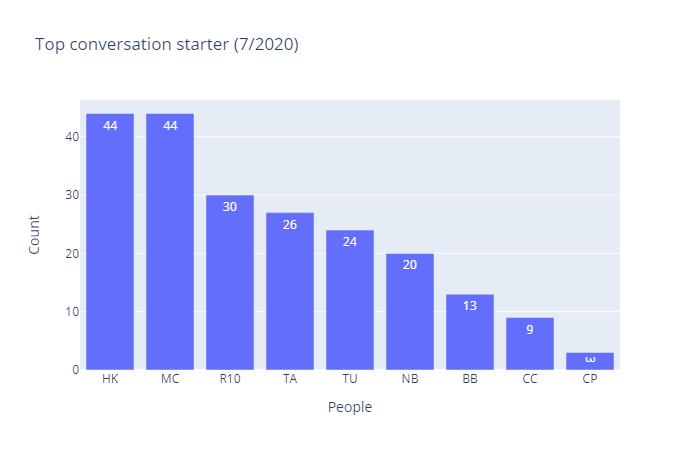

In [34]:
#number of messages per author
au = df3['Author']['first'].value_counts()

au = pd.DataFrame(au).reset_index()
au = au.rename(columns={'index':'People','first':'Count'})
ss=au[au['People']=='System'].index
au.drop(ss,inplace=True)
fig = px.bar(au,y='Count',x='People',title='Top conversation starter (7/2020)',
      text = ['44', '44', '30', 
     '26', '24', '20', '13', '9', '3'])
fig.show("png")

In [18]:
df3[df3['timestamp']['count']>100].sort_values('duration',ascending=False).head()

timestamp                           Author  \
                             min                 max count  first   
conversation                                                        
105          2020-07-15 06:16:00 2020-07-15 12:05:00   592     NB   
118          2020-07-17 07:31:00 2020-07-17 12:27:00   459     TA   
3            2020-07-01 12:13:00 2020-07-01 16:05:00   615     MC   
134          2020-07-20 08:59:00 2020-07-20 12:48:00   827     TU   
73           2020-07-10 07:11:00 2020-07-10 10:53:00   363    R10   

                                                                duration  
                                                 unique nunique           
conversation                                                              
105           [NB, TU, BB, TA, R10, MC, HK, CC, System]       9    349.0  
118               [TA, TU, R10, NB, MC, HK, CC, System]       8    296.0  
3             [MC, HK, TA, R10, CC, BB, TU, NB, System]       9    232.0  
134           [TU, TA, HK, R10, MC, NB, BB, CC, System]       9    229.0  
73                    [R10, BB, MC, HK, TU, NB, CC, TA]       8    222.0

In [19]:
df3['timestamp']['count'].mean()

68.53953488372093

In [20]:
import itertools  
x = thang7.Author.values

names = []; message_length = []
#generates a new group every time the value of the list changes
#https://docs.python.org/2/library/itertools.html#itertools.groupby
for k, g in itertools.groupby(x):
    names.append(k)
    message_length.append(len(list(g)))
    
df2 = pd.DataFrame(zip(names, message_length), columns=['sender', 'length'])

In [21]:
df2.groupby('sender')['length'].sum()

sender
BB         867
CC         790
CP          13
HK        3356
MC        3777
NB        1648
R10       2233
System      14
TA         657
TU        1370
TV          11
Name: length, dtype: int64

# Statistics

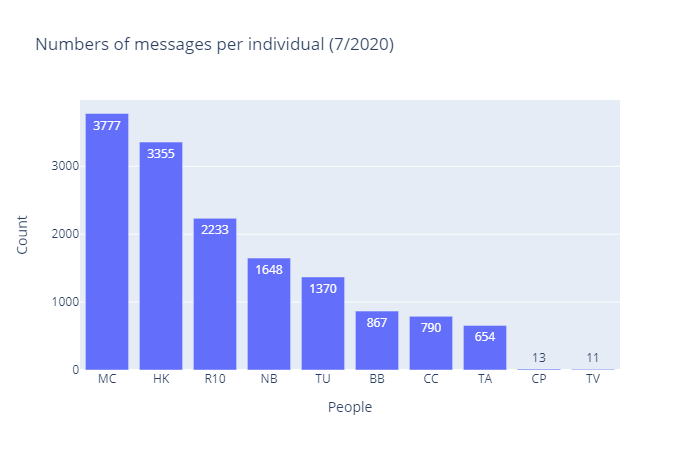

In [35]:
#number of messages per author
mess = thang7['Author'].value_counts()

mess = pd.DataFrame(mess).reset_index()
mess = mess.rename(columns={'index':'People','Author':'Count'})
ss=mess[mess['People']=='System'].index
mess.drop(ss,inplace=True)
fig = px.bar(mess,y='Count',x='People',title='Numbers of messages per individual (7/2020)',
      text = ['3777', '3355', '2233', 
     '1648', '1370', '867', '790', '654', '13', '11'])
fig.show("png")

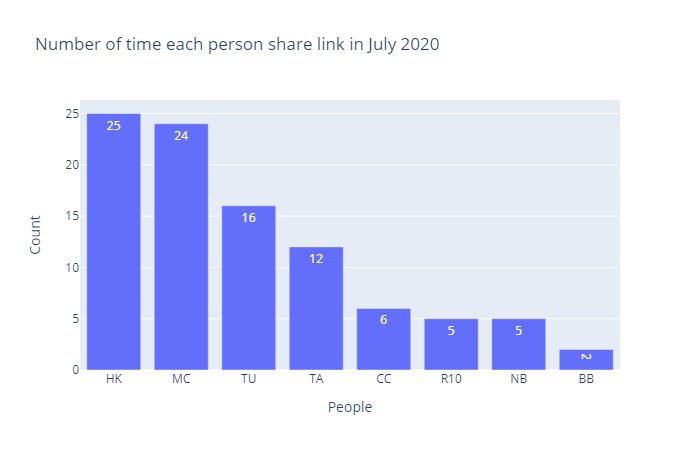

In [36]:
#share link http
sharelk = thang7[thang7['Message'].str.contains('https')==True]['Author'].value_counts()

sharelk = pd.DataFrame(sharelk).reset_index()
sharelk = sharelk.rename(columns={'index':'People','Author':'Count'})
fig = px.bar(sharelk,y='Count',x='People',title='Number of time each person share link in July 2020',
      text = ['25', '24', '16', 
     '12', '6', '5', '5', '2'])
fig.show("png")

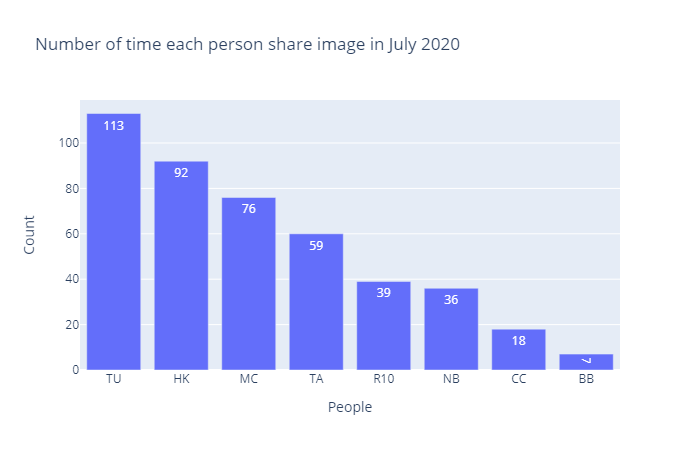

In [37]:
#times people share image or gif
shareim=thang7[thang7['Message'].str.contains('omitted')==True]['Author'].value_counts()


shareim = pd.DataFrame(shareim).reset_index()
shareim = shareim.rename(columns={'index':'People','Author':'Count'})
fig = px.bar(shareim,y='Count',x='People',title='Number of time each person share image in July 2020',
      text = ['113', '92', '76', 
     '59', '39', '36', '18', '7'])
fig.show("png")

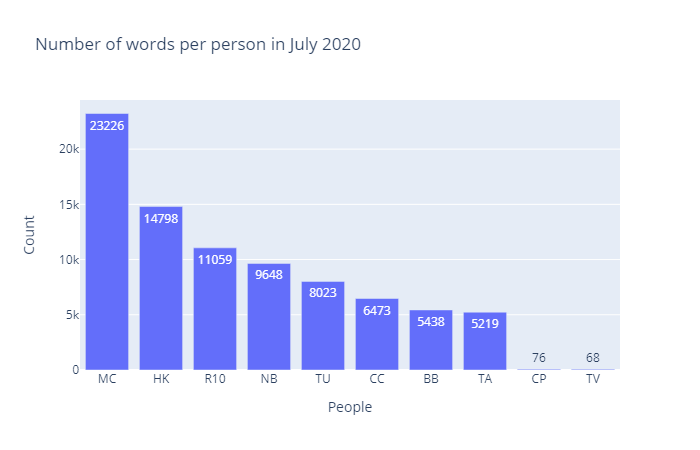

In [38]:
#number of words per author in the given period
words = thang7[['Author', 'Word_Count']].groupby('Author').sum().sort_values('Word_Count',ascending=False)

words = pd.DataFrame(words).reset_index()
words = words.rename(columns={'Author':'People','Word_Count':'Count'})
ss=words[words['People']=='System'].index
words.drop(ss,inplace=True)
fig = px.bar(words,y='Count',x='People',title='Number of words per person in July 2020',
     text = ['23226', '14798', '11059', 
     '9648', '8023', '6473', '5438', '5219','76','68'])
fig.show("png")

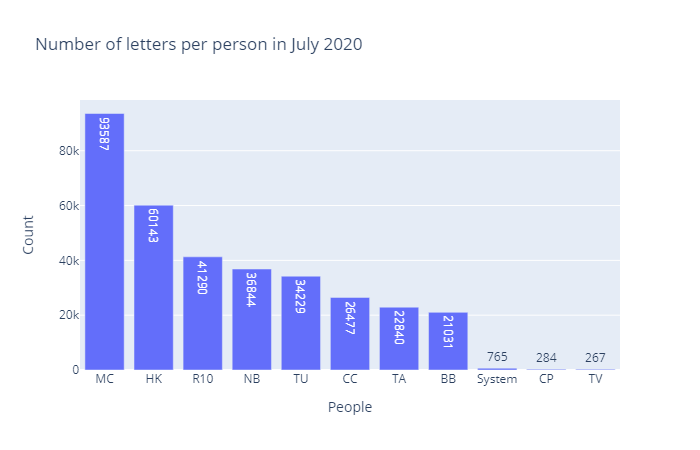

In [39]:
#number of letter per author in the given period
letters = thang7[['Author', 'Letter_Count']].groupby('Author').sum().sort_values('Letter_Count',ascending=False)

letters = pd.DataFrame(letters).reset_index()
letters = letters.rename(columns={'Author':'People','Letter_Count':'Count'})
fig = px.bar(letters,y='Count',x='People',title='Number of letters per person in July 2020',
     text = ['93587', '60143', '41290', '36844', '34229', '26477', '22840', '21031', '765', '284', '267'])
fig.show("png")

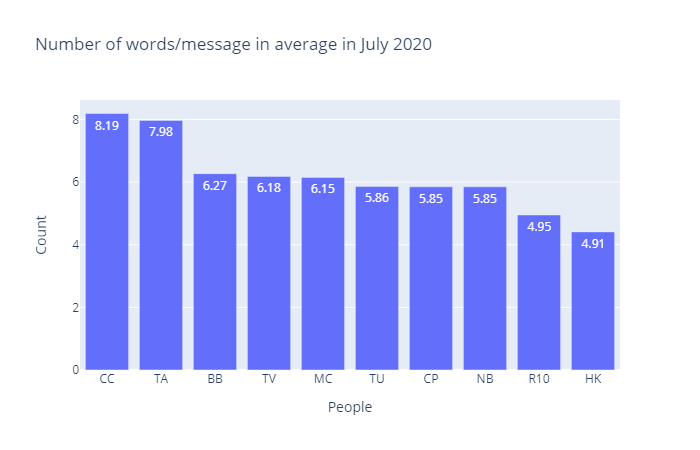

In [40]:
#Number of words per message in average
test = pd.DataFrame(thang7['Author'].value_counts())
test['Word_Count']=thang7[['Author', 'Word_Count']].groupby('Author').sum()
test['Words/Message']=round(test['Word_Count']/test['Author'],2)

wordmessage = test['Words/Message'].sort_values(ascending = False)
wordmessage = pd.DataFrame(wordmessage).reset_index()
wordmessage.drop(0,inplace=True)

wordmessage = wordmessage.rename(columns={'index':'People','Words/Message':'Count'})
fig = px.bar(wordmessage,y='Count',x='People',title='Number of words/message in average in July 2020',
     text = ['8.19', '7.98', '6.27', '6.18', '6.15', '5.86', '5.85', '5.85', '4.95', '4.91'])
fig.show("png")

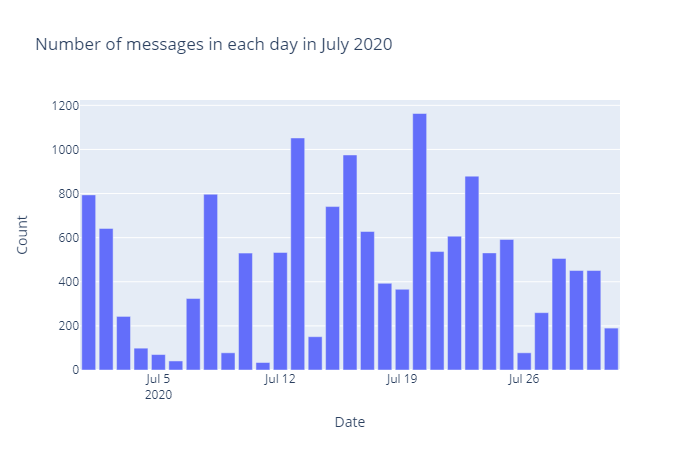

In [41]:
#number of messages/day
date = pd.DataFrame(thang7['Date'].value_counts()).reset_index()
date.sort_values('index')

date = date.rename(columns={'index':'Date','Date':'Count'})
fig = px.bar(date,y='Count',x='Date',title='Number of messages in each day in July 2020')
fig.show("png")

In [29]:
import string

mess = 'chúc anh em nhiều may mắn!' #an example string to test

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

In [30]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split()]

In [31]:
#set the text to lower character and process it
nga =thang7['Message'].apply(lambda x:x.lower()).values
ng = text_process(nga)


OK. The 20 most common words are as follows

là :  1134
có :  981
làm :  661
bạn :  641
thì :  638
nó :  605
cái :  577
t :  557
cho :  482
đi :  476
ko :  457
k :  404
mà :  387
này :  386
nói :  385
1 :  381
cũng :  367
lại :  361
phải :  359
ra :  326


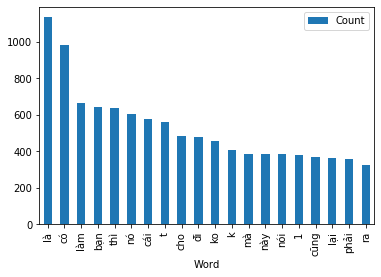

In [32]:
#COUNT THE TIME WORDS ARE USED
# Read input file, note the encoding is specified here 
#file = open('C:\\Users\\Chau Chu\\Documents\\Study\\Kaggle\\WS project\\WS 25-2 31-7.txt', encoding="utf8")
#a= file.read()
# Stopwords
#stopwords = set(line.strip() for line in open('stopwords.txt'))
#stopwords = ['có','thì','đi','mà','ko','rồi','thôi','lại','là','ờ',
           # 'làm', 'nó', 't', 'cho', 'k', 'cái','này', 'phải', 'với']
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in ng:
    word = word.replace("<","")
    word = word.replace(">","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("*","")
    word = word.replace("media","")
    word = word.replace("omitted","")
    word = word.replace(" ","")
    #if word not in stopwords:
    if len(word) >=1: #use it to filter the letter's length
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = 20
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
#file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

In [33]:
print('The no. of times that CC was mentioned: {}'.format(wordcount['châu']))
print('The no. of times that R10 (Viet) was mentioned: {}'.format(wordcount['r10'] + wordcount['việt']))
print('The no. of times that CP was mentioned: {}'.format(wordcount['chương']))
print('The no. of times that HK was mentioned: {}'.format(wordcount['hk']))
print('The no. of times that MC was mentioned: {}'.format(wordcount['mc']))
print('The no. of times that TA was mentioned: {}'.format(wordcount['tuấn']))
print('The no. of times that TU was mentioned: {}'.format(wordcount['tú']))
print('The no. of times that BB was mentioned: {}'.format(wordcount['bách']))
print('The no. of times that nb was mentioned: {}'.format(wordcount['nb']))

The no. of times that CC was mentioned: 35
The no. of times that R10 (Viet) was mentioned: 291
The no. of times that CP was mentioned: 12
The no. of times that HK was mentioned: 79
The no. of times that MC was mentioned: 64
The no. of times that TA was mentioned: 36
The no. of times that TU was mentioned: 67
The no. of times that BB was mentioned: 22
The no. of times that nb was mentioned: 34
